In [1]:

import pandas as pd
from datasets import Dataset,DatasetDict
from transformers import AutoTokenizer,AutoModelForMultipleChoice, TrainingArguments, Trainer, BitsAndBytesConfig
from accelerate import Accelerator
import peft
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
import datetime
import numpy as np


/home/mowgli/miniconda3/envs/textgen2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')

In [3]:
examples = pd.read_csv('60k_data/all_12_with_context2.csv')

In [4]:
train.drop_duplicates(subset=['prompt'],inplace=True)
examples.drop_duplicates(subset=['prompt'],inplace=True)


In [5]:

sentences = [example for example in examples['prompt']]

In [6]:

sentences = [example for example in examples['prompt']]
sentences.extend(train['prompt'].tolist())

In [7]:
pd.concat([examples,train])

,prompt,context,A,B,C,D,E,answer,source,id
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1.0,NaN
1,How does Modified Newtonian Dynamics (MOND) im...,The presence of a clustered thick disk-like co...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1.0,NaN
2,Which of the following statements accurately d...,Woody Hartman is a retired American soccer goa...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1.0,NaN
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1.0,NaN
4,What was the previous name of the Christian Sc...,It was named the Evangelical School for the De...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
195,What is the relation between the three moment ...,NaN,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,NaN,195.0
196,"What is the throttling process, and why is it ...",NaN,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,NaN,196.0
197,What happens to excess base metal as a solutio...,NaN,"The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,NaN,197.0
198,"What is the relationship between mass, force, ...",NaN,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,NaN,198.0


In [8]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
# sentences = ["This is an example sentence", "Each sentence is converted"]

# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')# too large to encode entire dataset, use bert
model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(sentences)
# print(embeddings)

In [9]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached umap_learn-0.5.4-py3-none-any.whl


In [11]:
import umap

In [12]:
# from umap import umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [13]:
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819552 sha256=e59699fc11c36e44be6b7eb0d41fb3bfc7eb2303c1eda593d55f498367ed6021
  Stored in directory: /home/mowgli/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [14]:

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

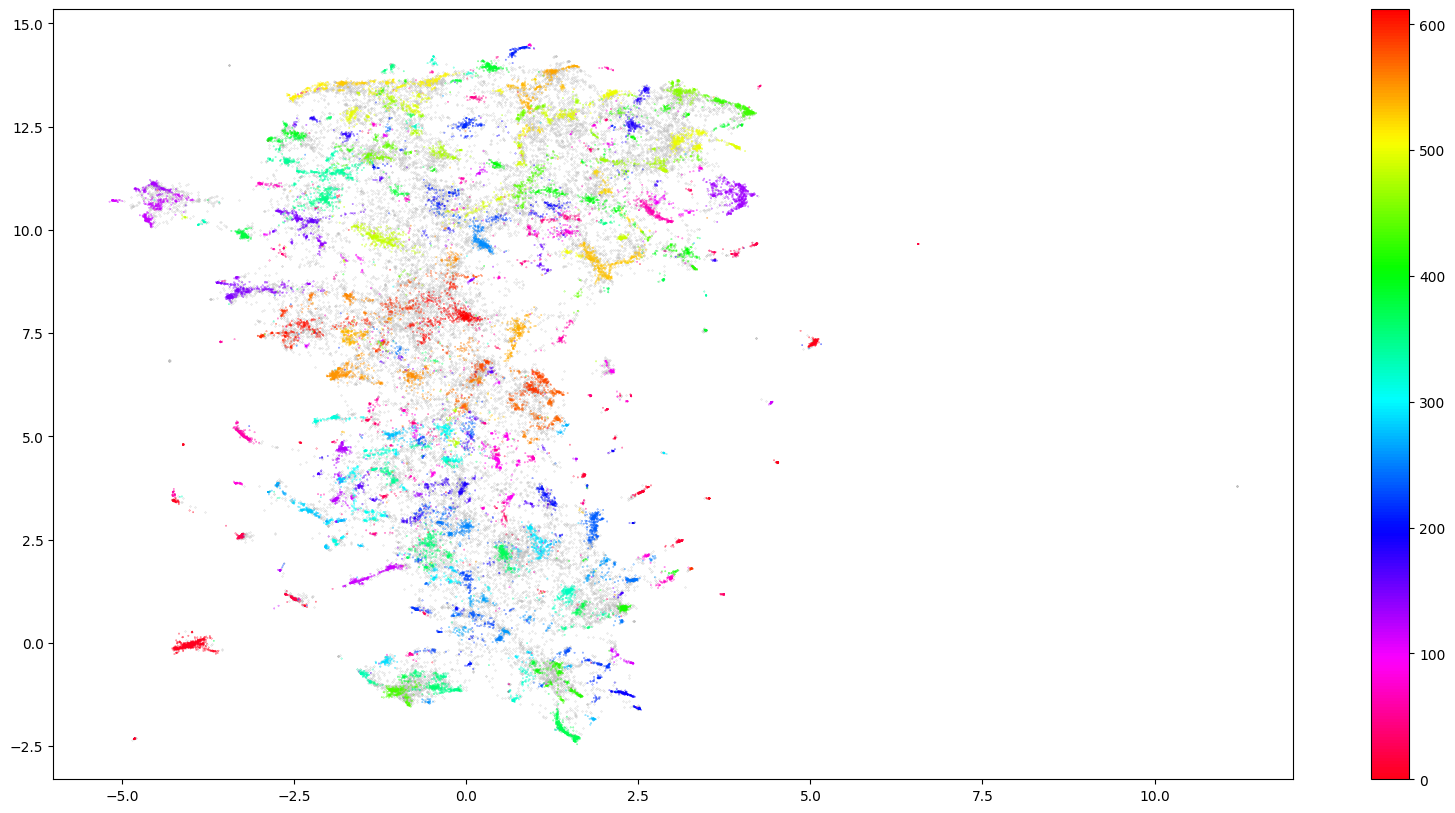

In [17]:


import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()